# Red convolucional con mecanismos atencionales

In [1]:
import math
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(1)

## Definición de hiperparámetros

In [164]:
epochs=200
batch_size=100
lr=0.001

## Carga de datos de los datasets

In [165]:
# train_data = torchvision.datasets.CIFAR10(
#     root='./cifar10/',
#     train=True,
#     transform=torchvision.transforms.ToTensor(),
#     download=True,                                  
# )

# test_data = torchvision.datasets.CIFAR10(
#     root='./cifar10/',
#     train=False,
#     transform=torchvision.transforms.ToTensor(),
#     download=True,
# )

train_data = torchvision.datasets.CIFAR100(
    root='../Notebooks/data/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,                                  
)

test_data = torchvision.datasets.CIFAR100(
    root='../Notebooks/data/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

train_img, train_label = train_data.__getitem__(0)
test_img, test_label = test_data.__getitem__(0)

print(len(train_data), train_img.size())
print(len(test_data), test_img.size())

train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader  = Data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
50000 torch.Size([3, 32, 32])
10000 torch.Size([3, 32, 32])


## Funciones de ayuda para imprimir mapas de calor de los mecanismos atencionales

In [166]:
import matplotlib.pyplot as plt

def print_hot_map_S(att_array):
    att_array = att_array.detach()
#     print(att_array)
#     print(att_array.size())
    
    plt.imshow(att_array.numpy()[0][0])
    plt.title("Mecanismo atencional de espacio")
    plt.show()
    
def print_hot_map_C(att_array):
    att_array = torch.reshape(att_array.detach(), (-1,))
#     print(att_array)
#     print(att_array.size())
    
    plt.plot(att_array)
    plt.xlabel("Channels")
    plt.ylabel("Grado de atención")
    plt.title("Mecanismo atencional de canales")
    plt.show()
    
should_print_hot_map=False

## Clases que implementan los mecanismos atencionales

En primer lugar se definen las clases minoritarias, que serán aquellas que compondrán la red principal.

A continuación, se compone una red utilizando las clases definidas anteriormente. Esta red, mediante el uso de banderas en el constructor, puede o no incluir mecanismos atencionales (canales, espacial, ambos o ninguno).

### Filtro espacial
Consiste en un pequeño autoencoder, que al comprimir y descomprimir la imagen permite eliminar parte del ruido de la misma.
    
### Filtro de canales
Es capaz de seleccionar las zonas de la imagen en las que algún canal gana importancia respecto a la característica buscada, y se encarga de resaltar dicha sección de la imagen.

In [167]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, in_planes, reduction_ratio=16):
        super(ChannelGate, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // reduction_ratio, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // reduction_ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        
        if should_print_hot_map:
            print_hot_map_C(self.sigmoid(out).cpu())
            
        return self.sigmoid(out) * x

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        
        if should_print_hot_map:
            print_hot_map_S(scale.cpu()) # Usamos esto para el mapa de calor
            
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, spatial=True, channel=True):
        super(CBAM, self).__init__()
        self.spatial=spatial
        self.channel=channel
        if channel:
            self.ChannelGate = ChannelGate(gate_channels, reduction_ratio=reduction_ratio)
        if spatial:
            self.SpatialGate = SpatialGate()
    
    def forward(self, x):
        if self.channel:
            x = self.ChannelGate(x)
        if self.spatial:
            x = self.SpatialGate(x)
        return x
    
class Convolutional(nn.Module):
    def __init__(self, in_size):
        super(Convolutional, self).__init__()
        self.conv1 = nn.Conv2d(in_size, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x
    
class model (nn.Module):
    def __init__(self, spatial_=True, channel_=True):
        super(model, self).__init__()
        self.att = channel_ or spatial_
        self.conv_ini = nn.Conv2d(3, 32, 1)
        if channel_ or spatial_:
            self.layer1 = CBAM(32, spatial=spatial_, channel=channel_, reduction_ratio=16)
        self.layer2 = Convolutional(32)
        self.fc = nn.Linear(400, 100)
    
    def forward(self, x):
        x = self.conv_ini(x)
        if self.att:
            x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
modelNONE = model(spatial_=False, channel_=False).cuda()
modelS = model(channel_=False).cuda()
modelC = model(spatial_=False).cuda()
modelSC = model().cuda()

## Módulo para obtener la precisión de la red

In [168]:
def get_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    for imgs, labels in dataloader:
        output = model(imgs.cuda())
        labels = labels.cuda()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    model.train()
    return correct / total

## Elección del modelo y entrenamiento

En cada época se muestra el resultado del entrenamiento

In [169]:
def trainModel(model):
    history_train_loss = []
    history_test_loss = []
    history_train_acc = []
    history_test_acc = []
    
    
    optimizer = torch.optim.Adam(model.parameters())
    loss_func = nn.CrossEntropyLoss().cuda()
    
    for epoch in range(epochs):
        model.train()
        lossestr = []
        for step, (x, y) in enumerate(train_loader):
            x = torch.autograd.Variable(x.cuda())
            y = torch.autograd.Variable(y.cuda())

            out = model(x)
            loss = loss_func(out, y)
            lossestr.append(loss.item())

            optimizer.zero_grad()
            loss.backward()                    
            optimizer.step()                   

        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                losseste = []
                for step, (x, y) in enumerate(test_loader):
                    x = torch.autograd.Variable(x.cuda())
                    y = torch.autograd.Variable(y.cuda())
                    out = model(x)
                    loss = loss_func(out, y)
                    losseste.append(loss.item())
            model.train()
            acctr = get_accuracy(model, train_loader)
            accte = get_accuracy(model, test_loader)

        print('Epoch: ', epoch, '| train loss: %.4f' % (sum(lossestr)/len(lossestr)), 
                                '| test loss:  %.4f' % (sum(losseste)/len(losseste)),
                                '| train acc:  %.4f' % acctr,
                                '| test acc:   %.4f' % accte)
        
        history_train_loss.append(sum(lossestr)/len(lossestr))
        history_test_loss.append(sum(losseste)/len(losseste))
        history_train_acc.append(acctr)
        history_test_acc.append(accte)
        
        
    return history_train_loss, history_test_loss, history_train_acc, history_test_acc

https://github.com/Jongchan/attention-module

In [170]:
modelNONE_train_loss, modelNONE_test_loss, modelNONE_train_acc, modelNONE_test_acc = trainModel(modelNONE)

Epoch:  0 | train loss: 3.9217 | test loss:  3.6170 | train acc:  0.1775 | test acc:   0.1622
Epoch:  1 | train loss: 3.4816 | test loss:  3.4579 | train acc:  0.2180 | test acc:   0.1956
Epoch:  2 | train loss: 3.3269 | test loss:  3.3888 | train acc:  0.2409 | test acc:   0.2129
Epoch:  3 | train loss: 3.2284 | test loss:  3.3306 | train acc:  0.2554 | test acc:   0.2244
Epoch:  4 | train loss: 3.1591 | test loss:  3.3227 | train acc:  0.2590 | test acc:   0.2249
Epoch:  5 | train loss: 3.1015 | test loss:  3.2558 | train acc:  0.2778 | test acc:   0.2367
Epoch:  6 | train loss: 3.0501 | test loss:  3.2532 | train acc:  0.2827 | test acc:   0.2434
Epoch:  7 | train loss: 3.0115 | test loss:  3.2753 | train acc:  0.2831 | test acc:   0.2323
Epoch:  8 | train loss: 2.9749 | test loss:  3.2275 | train acc:  0.2995 | test acc:   0.2444
Epoch:  9 | train loss: 2.9473 | test loss:  3.2202 | train acc:  0.3046 | test acc:   0.2522
Epoch:  10 | train loss: 2.9199 | test loss:  3.1949 | train

Epoch:  87 | train loss: 2.3432 | test loss:  3.1271 | train acc:  0.4241 | test acc:   0.2775
Epoch:  88 | train loss: 2.3417 | test loss:  3.1098 | train acc:  0.4326 | test acc:   0.2861
Epoch:  89 | train loss: 2.3352 | test loss:  3.1023 | train acc:  0.4313 | test acc:   0.2799
Epoch:  90 | train loss: 2.3348 | test loss:  3.1384 | train acc:  0.4254 | test acc:   0.2797
Epoch:  91 | train loss: 2.3303 | test loss:  3.1100 | train acc:  0.4309 | test acc:   0.2842
Epoch:  92 | train loss: 2.3282 | test loss:  3.1252 | train acc:  0.4273 | test acc:   0.2814
Epoch:  93 | train loss: 2.3298 | test loss:  3.1237 | train acc:  0.4300 | test acc:   0.2825
Epoch:  94 | train loss: 2.3238 | test loss:  3.1392 | train acc:  0.4298 | test acc:   0.2821
Epoch:  95 | train loss: 2.3221 | test loss:  3.1264 | train acc:  0.4290 | test acc:   0.2829
Epoch:  96 | train loss: 2.3206 | test loss:  3.1466 | train acc:  0.4293 | test acc:   0.2802
Epoch:  97 | train loss: 2.3146 | test loss:  3.11

Epoch:  173 | train loss: 2.2118 | test loss:  3.1610 | train acc:  0.4502 | test acc:   0.2808
Epoch:  174 | train loss: 2.2085 | test loss:  3.1556 | train acc:  0.4523 | test acc:   0.2795
Epoch:  175 | train loss: 2.2090 | test loss:  3.1666 | train acc:  0.4531 | test acc:   0.2809
Epoch:  176 | train loss: 2.2051 | test loss:  3.1696 | train acc:  0.4565 | test acc:   0.2789
Epoch:  177 | train loss: 2.2070 | test loss:  3.1621 | train acc:  0.4528 | test acc:   0.2810
Epoch:  178 | train loss: 2.2076 | test loss:  3.1793 | train acc:  0.4523 | test acc:   0.2784
Epoch:  179 | train loss: 2.2086 | test loss:  3.1482 | train acc:  0.4517 | test acc:   0.2783
Epoch:  180 | train loss: 2.2048 | test loss:  3.1659 | train acc:  0.4549 | test acc:   0.2796
Epoch:  181 | train loss: 2.2038 | test loss:  3.1485 | train acc:  0.4581 | test acc:   0.2799
Epoch:  182 | train loss: 2.2063 | test loss:  3.1626 | train acc:  0.4499 | test acc:   0.2780
Epoch:  183 | train loss: 2.2033 | test 

In [171]:
modelS_train_loss, modelS_test_loss, modelS_train_acc, modelS_test_acc = trainModel(modelS)

Epoch:  0 | train loss: 4.0423 | test loss:  3.7262 | train acc:  0.1640 | test acc:   0.1505
Epoch:  1 | train loss: 3.5667 | test loss:  3.5200 | train acc:  0.2055 | test acc:   0.1857
Epoch:  2 | train loss: 3.3821 | test loss:  3.4708 | train acc:  0.2232 | test acc:   0.2005
Epoch:  3 | train loss: 3.2643 | test loss:  3.4250 | train acc:  0.2315 | test acc:   0.2027
Epoch:  4 | train loss: 3.1769 | test loss:  3.3098 | train acc:  0.2704 | test acc:   0.2269
Epoch:  5 | train loss: 3.1104 | test loss:  3.2945 | train acc:  0.2769 | test acc:   0.2311
Epoch:  6 | train loss: 3.0598 | test loss:  3.2633 | train acc:  0.2854 | test acc:   0.2356
Epoch:  7 | train loss: 3.0167 | test loss:  3.2713 | train acc:  0.2889 | test acc:   0.2413
Epoch:  8 | train loss: 2.9814 | test loss:  3.2552 | train acc:  0.2959 | test acc:   0.2419
Epoch:  9 | train loss: 2.9469 | test loss:  3.2187 | train acc:  0.3039 | test acc:   0.2391
Epoch:  10 | train loss: 2.9248 | test loss:  3.2017 | train

Epoch:  87 | train loss: 2.4356 | test loss:  3.1886 | train acc:  0.3968 | test acc:   0.2705
Epoch:  88 | train loss: 2.4307 | test loss:  3.1478 | train acc:  0.4058 | test acc:   0.2746
Epoch:  89 | train loss: 2.4312 | test loss:  3.2373 | train acc:  0.4049 | test acc:   0.2698
Epoch:  90 | train loss: 2.4294 | test loss:  3.1624 | train acc:  0.4060 | test acc:   0.2679
Epoch:  91 | train loss: 2.4287 | test loss:  3.2753 | train acc:  0.4003 | test acc:   0.2699
Epoch:  92 | train loss: 2.4260 | test loss:  3.2097 | train acc:  0.4072 | test acc:   0.2725
Epoch:  93 | train loss: 2.4229 | test loss:  3.1889 | train acc:  0.4093 | test acc:   0.2746
Epoch:  94 | train loss: 2.4225 | test loss:  3.1475 | train acc:  0.4088 | test acc:   0.2715
Epoch:  95 | train loss: 2.4228 | test loss:  3.1945 | train acc:  0.4041 | test acc:   0.2745
Epoch:  96 | train loss: 2.4177 | test loss:  3.1974 | train acc:  0.4099 | test acc:   0.2729
Epoch:  97 | train loss: 2.4171 | test loss:  3.18

Epoch:  173 | train loss: 2.3337 | test loss:  3.3310 | train acc:  0.4157 | test acc:   0.2754
Epoch:  174 | train loss: 2.3338 | test loss:  3.2257 | train acc:  0.4250 | test acc:   0.2783
Epoch:  175 | train loss: 2.3303 | test loss:  3.1818 | train acc:  0.4216 | test acc:   0.2770
Epoch:  176 | train loss: 2.3335 | test loss:  3.1948 | train acc:  0.4274 | test acc:   0.2801
Epoch:  177 | train loss: 2.3304 | test loss:  3.2240 | train acc:  0.4114 | test acc:   0.2723
Epoch:  178 | train loss: 2.3293 | test loss:  3.2607 | train acc:  0.4260 | test acc:   0.2776
Epoch:  179 | train loss: 2.3283 | test loss:  3.2255 | train acc:  0.4269 | test acc:   0.2763
Epoch:  180 | train loss: 2.3247 | test loss:  3.2015 | train acc:  0.4264 | test acc:   0.2755
Epoch:  181 | train loss: 2.3279 | test loss:  3.2020 | train acc:  0.4253 | test acc:   0.2785
Epoch:  182 | train loss: 2.3234 | test loss:  3.2616 | train acc:  0.4217 | test acc:   0.2737
Epoch:  183 | train loss: 2.3268 | test 

In [172]:
modelC_train_loss, modelC_test_loss, modelC_train_acc, modelC_test_acc = trainModel(modelC)

Epoch:  0 | train loss: 4.6061 | test loss:  4.6053 | train acc:  0.0100 | test acc:   0.0100
Epoch:  1 | train loss: 4.6057 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  2 | train loss: 4.6057 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  3 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  4 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  5 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  6 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  7 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  8 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  9 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  10 | train loss: 4.6056 | test loss:  4.6052 | train

Epoch:  87 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  88 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  89 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  90 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  91 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  92 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  93 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  94 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  95 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  96 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  97 | train loss: 4.6056 | test loss:  4.60

Epoch:  173 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  174 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  175 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  176 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  177 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  178 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  179 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  180 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  181 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  182 | train loss: 4.6056 | test loss:  4.6052 | train acc:  0.0100 | test acc:   0.0100
Epoch:  183 | train loss: 4.6056 | test 

In [173]:
modelSC_train_loss, modelSC_test_loss, modelSC_train_acc, modelSC_test_acc = trainModel(modelSC)

Epoch:  0 | train loss: 3.9665 | test loss:  3.6917 | train acc:  0.1619 | test acc:   0.1543
Epoch:  1 | train loss: 3.5124 | test loss:  3.4493 | train acc:  0.2106 | test acc:   0.1992
Epoch:  2 | train loss: 3.3347 | test loss:  3.3517 | train acc:  0.2391 | test acc:   0.2196
Epoch:  3 | train loss: 3.2169 | test loss:  3.2927 | train acc:  0.2521 | test acc:   0.2246
Epoch:  4 | train loss: 3.1273 | test loss:  3.2704 | train acc:  0.2653 | test acc:   0.2333
Epoch:  5 | train loss: 3.0668 | test loss:  3.2145 | train acc:  0.2791 | test acc:   0.2546
Epoch:  6 | train loss: 3.0176 | test loss:  3.1466 | train acc:  0.2877 | test acc:   0.2560
Epoch:  7 | train loss: 2.9711 | test loss:  3.1356 | train acc:  0.2974 | test acc:   0.2543
Epoch:  8 | train loss: 2.9386 | test loss:  3.1126 | train acc:  0.3049 | test acc:   0.2669
Epoch:  9 | train loss: 2.9073 | test loss:  3.0988 | train acc:  0.3111 | test acc:   0.2680
Epoch:  10 | train loss: 2.8842 | test loss:  3.2630 | train

Epoch:  87 | train loss: 2.3474 | test loss:  2.8808 | train acc:  0.4242 | test acc:   0.3099
Epoch:  88 | train loss: 2.3454 | test loss:  2.9843 | train acc:  0.3739 | test acc:   0.2810
Epoch:  89 | train loss: 2.3442 | test loss:  2.8834 | train acc:  0.4223 | test acc:   0.3112
Epoch:  90 | train loss: 2.3415 | test loss:  2.9396 | train acc:  0.4224 | test acc:   0.3075
Epoch:  91 | train loss: 2.3364 | test loss:  2.9489 | train acc:  0.4193 | test acc:   0.3074
Epoch:  92 | train loss: 2.3366 | test loss:  2.8956 | train acc:  0.4229 | test acc:   0.3103
Epoch:  93 | train loss: 2.3355 | test loss:  2.8765 | train acc:  0.4244 | test acc:   0.3111
Epoch:  94 | train loss: 2.3302 | test loss:  2.9638 | train acc:  0.4182 | test acc:   0.3087
Epoch:  95 | train loss: 2.3296 | test loss:  2.8808 | train acc:  0.4127 | test acc:   0.3010
Epoch:  96 | train loss: 2.3249 | test loss:  2.9136 | train acc:  0.4178 | test acc:   0.3031
Epoch:  97 | train loss: 2.3220 | test loss:  2.94

Epoch:  173 | train loss: 2.2183 | test loss:  2.9721 | train acc:  0.4433 | test acc:   0.3112
Epoch:  174 | train loss: 2.2200 | test loss:  2.9305 | train acc:  0.4416 | test acc:   0.3145
Epoch:  175 | train loss: 2.2199 | test loss:  2.8731 | train acc:  0.4396 | test acc:   0.3136
Epoch:  176 | train loss: 2.2203 | test loss:  2.9331 | train acc:  0.4412 | test acc:   0.3107
Epoch:  177 | train loss: 2.2186 | test loss:  2.8940 | train acc:  0.4499 | test acc:   0.3123
Epoch:  178 | train loss: 2.2180 | test loss:  2.8833 | train acc:  0.4499 | test acc:   0.3177
Epoch:  179 | train loss: 2.2177 | test loss:  2.8680 | train acc:  0.4283 | test acc:   0.3025
Epoch:  180 | train loss: 2.2162 | test loss:  2.8927 | train acc:  0.4365 | test acc:   0.3070
Epoch:  181 | train loss: 2.2151 | test loss:  2.9001 | train acc:  0.4484 | test acc:   0.3157
Epoch:  182 | train loss: 2.2134 | test loss:  2.9199 | train acc:  0.4426 | test acc:   0.3127
Epoch:  183 | train loss: 2.2137 | test 

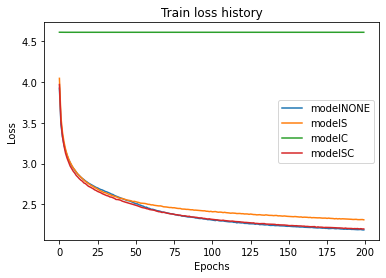

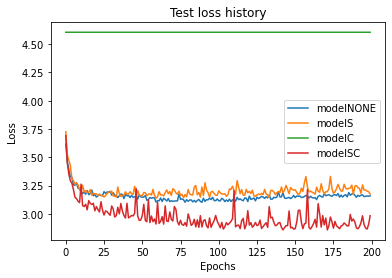

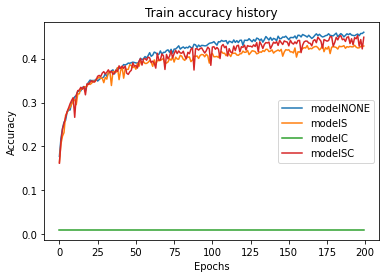

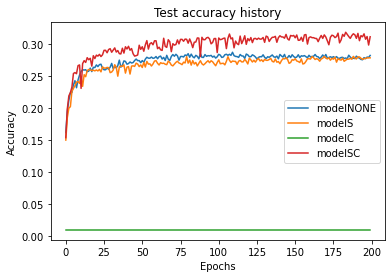

In [174]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(modelNONE_train_loss, label="modelNONE")
ax.plot(modelS_train_loss, label="modelS")
ax.plot(modelC_train_loss, label="modelC")
ax.plot(modelSC_train_loss, label="modelSC")
plt.title("Train loss history")
plt.ylabel("Loss")
plt.xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(modelNONE_test_loss, label="modelNONE")
ax.plot(modelS_test_loss, label="modelS")
ax.plot(modelC_test_loss, label="modelC")
ax.plot(modelSC_test_loss, label="modelSC")
plt.title("Test loss history")
plt.ylabel("Loss")
plt.xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(modelNONE_train_acc, label="modelNONE")
ax.plot(modelS_train_acc, label="modelS")
ax.plot(modelC_train_acc, label="modelC")
ax.plot(modelSC_train_acc, label="modelSC")
plt.title("Train accuracy history")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(modelNONE_test_acc, label="modelNONE")
ax.plot(modelS_test_acc, label="modelS")
ax.plot(modelC_test_acc, label="modelC")
ax.plot(modelSC_test_acc, label="modelSC")
plt.title("Test accuracy history")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
ax.legend()
plt.show()

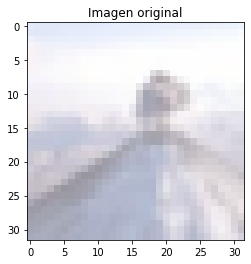

mountain
********************** modelS **********************


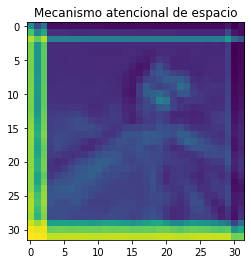

********************** modelC **********************


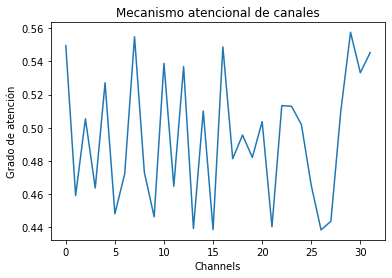

********************** modelSC **********************


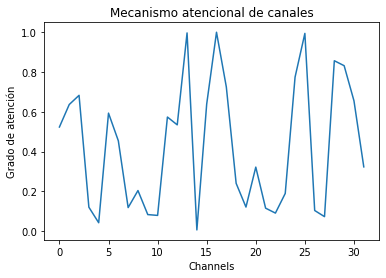

/home/alvaro/anaconda3/envs/arqesp/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


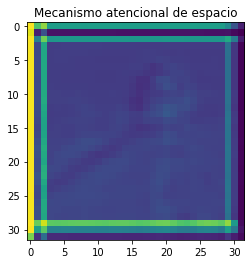

Clase estimada modelNONE:	 bridge 	, loss ->  4.3800153732299805
Clase estimada modelS:		 dolphin 	, loss ->  2.6290595531463623
Clase estimada modelC:		 motorcycle 	, loss ->  4.604766368865967
Clase estimada modelSC:		 mountain 	, loss ->  0.09576861560344696


In [175]:
import numpy as np

classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'] 

def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.title("Imagen original")
    plt.show()
    
should_print_hot_map = True
    
img_loader = Data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)
img_iter = iter(img_loader)
images, labels = next(img_iter)

imshow(torchvision.utils.make_grid(images))
print(classes[labels])

loss_func = nn.CrossEntropyLoss()

images = images.cuda()
out_NONE = modelNONE(images).cpu()
print("********************** modelS **********************")
out_S = modelS(images).cpu()
print("********************** modelC **********************")
out_C = modelC(images).cpu()
print("********************** modelSC **********************")
out_SC = modelSC(images).cpu()


_, predicted_NONE = torch.max(out_NONE.data, 1)
_, predicted_S = torch.max(out_S.data, 1)
_, predicted_C = torch.max(out_C.data, 1)
_, predicted_SC = torch.max(out_SC.data, 1)

print("Clase estimada modelNONE:\t", classes[predicted_NONE.item()], "\t, loss -> ", loss_func(out_NONE, labels).item())
print("Clase estimada modelS:\t\t", classes[predicted_S.item()], "\t, loss -> ", loss_func(out_S, labels).item())
print("Clase estimada modelC:\t\t", classes[predicted_C.item()], "\t, loss -> ", loss_func(out_C, labels).item())
print("Clase estimada modelSC:\t\t", classes[predicted_SC.item()], "\t, loss -> ", loss_func(out_SC, labels).item())